# 백테스트
- 수수료 : 왕복 거래시: 매수 0.1% + 매도 0.1% = 총 0.2%

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class SimpleBacktester:
    def __init__(self, data_path, start_date='2021-09-07', end_date='2023-12-31'):
        """
        예측 라벨용 개별 종목 백테스터 (신호 반전)
        """
        self.data_path = data_path
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.stocks_data = {}
        self.results = {}
        
        self.top_performers = []
        self.top_performers_dict = {}
        
        self.top_strategy_performers = []
        self.top_strategy_performers_dict = {}
        
    def load_data(self):
        """CSV 파일들 로딩 - 각 종목의 실제 테스트 기간 사용"""
        patterns = ["*.csv"]
        csv_files = []
        
        for pattern in patterns:
            files = glob.glob(os.path.join(self.data_path, pattern))
            if files:
                csv_files = files
                print(f"파일 패턴 발견: {pattern} ({len(files)}개)")
                break
        
        if not csv_files:
            raise FileNotFoundError(f"CSV 파일을 찾을 수 없습니다: {self.data_path}")
        
        print(f"CSV 파일 로딩 중... ({len(csv_files)}개)")
        print("각 종목의 실제 테스트 기간을 사용합니다.")
        
        for file_path in tqdm(csv_files):
            try:
                filename = os.path.basename(file_path)
                symbol = filename.replace('_pure_backtest.csv', '')
                
                df = pd.read_csv(file_path)
                
                if 'Date' in df.columns:
                    df['Date'] = pd.to_datetime(df['Date'])
                else:
                    continue
                
                required_cols = ['Date', 'Close', 'Predicted_Label', 'Predicted_Action']
                if not all(col in df.columns for col in required_cols):
                    print(f"필수 컬럼 누락: {symbol}")
                    continue

                df['Label'] = df['Predicted_Label']
                df['Label_Name'] = df['Predicted_Action']
                df = df.sort_values('Date').reset_index(drop=True)

                if len(df) > 30:  # 최소 30일 데이터 필요
                    self.stocks_data[symbol] = df
                    print(f"  {symbol}: {df['Date'].min().date()} ~ {df['Date'].max().date()} ({len(df)}일)")
                else:
                    print(f"  제외: {symbol} (데이터 {len(df)}일로 부족)")
                    
            except Exception as e:
                print(f"파일 로딩 실패: {filename} - {e}")
        
        print(f"\n로딩 완료: {len(self.stocks_data)}개 종목")
        print("주의: 각 종목마다 다른 테스트 기간을 사용하므로 절대 수익률 비교에 유의하세요.")
        return self.stocks_data
    
    def simulate_trading(self, symbol, initial_capital=10000, transaction_cost=0.001):
        """예측 라벨 기반 매매 시뮬레이션 (정상 신호)"""
        
        df = self.stocks_data[symbol].copy()
        
        cash = initial_capital
        shares = 0
        portfolio_values = []
        trades = []
        position = 'CASH'
        
        for idx, row in df.iterrows():
            date = row['Date']
            current_price = row['Close']
            predicted_action = row['Predicted_Action']
            
            portfolio_value = cash + (shares * current_price)
            portfolio_values.append(portfolio_value)
            
            # 정상 신호: Buy → 매수, Sell → 매도
            if predicted_action == 'Buy' and position == 'CASH':
                shares_to_buy = cash / (current_price * (1 + transaction_cost))
                if shares_to_buy > 0:
                    shares += shares_to_buy
                    cash -= shares_to_buy * current_price * (1 + transaction_cost)
                    position = 'LONG'
                    
                    trades.append({
                        'date': date,
                        'action': 'BUY',
                        'price': current_price,
                        'shares': shares_to_buy,
                        'value': shares_to_buy * current_price,
                        'label': predicted_action
                    })
            
            elif predicted_action == 'Sell' and position == 'LONG':
                if shares > 0:
                    sale_value = shares * current_price * (1 - transaction_cost)
                    cash += sale_value
                    
                    trades.append({
                        'date': date,
                        'action': 'SELL',
                        'price': current_price,
                        'shares': shares,
                        'value': sale_value,
                        'label': predicted_action
                    })
                    
                    shares = 0
                    position = 'CASH'
        
        if shares > 0:
            final_price = df.iloc[-1]['Close']
            final_date = df.iloc[-1]['Date']
            final_value = shares * final_price * (1 - transaction_cost)
            cash += final_value
            
            trades.append({
                'date': final_date,
                'action': 'FINAL_SELL',
                'price': final_price,
                'shares': shares,
                'value': final_value,
                'label': 'FINAL'
            })
        
        df['Portfolio_Value'] = portfolio_values
        final_value = cash
        total_return = (final_value - initial_capital) / initial_capital
        
        buy_hold_return = (df.iloc[-1]['Close'] - df.iloc[0]['Close']) / df.iloc[0]['Close']
        
        daily_returns = df['Portfolio_Value'].pct_change().dropna()
        sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if daily_returns.std() > 0 else 0
        
        peak = df['Portfolio_Value'].expanding().max()
        drawdown = (df['Portfolio_Value'] - peak) / peak
        max_drawdown = drawdown.min()
        
        trade_returns = []
        for i in range(0, len(trades)-1, 2):
            if i+1 < len(trades) and trades[i]['action'] == 'BUY' and trades[i+1]['action'] in ['SELL', 'FINAL_SELL']:
                buy_trade = trades[i]
                sell_trade = trades[i+1]
                trade_return = (sell_trade['price'] - buy_trade['price']) / buy_trade['price']
                trade_returns.append(trade_return)
        
        win_rate = sum(1 for r in trade_returns if r > 0) / len(trade_returns) if trade_returns else 0
        avg_trade_return = np.mean(trade_returns) if trade_returns else 0
        
        return {
            'symbol': symbol,
            'initial_capital': initial_capital,
            'final_value': final_value,
            'total_return': total_return,
            'buy_hold_return': buy_hold_return,
            'excess_return': total_return - buy_hold_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'num_trades': len(trades),
            'win_rate': win_rate,
            'avg_trade_return': avg_trade_return,
            'trades': trades,
            'portfolio_values': df['Portfolio_Value'].values,
            'dates': df['Date'].values
        }
    
    def run_all_stocks_backtest(self, initial_capital=10000):
        """모든 종목에 대해 백테스팅 실행"""
        print(f"\n모든 종목 ({len(self.stocks_data)}개)에 대해 백테스팅 실행 중...")
        
        for symbol in tqdm(self.stocks_data.keys()):
            result = self.simulate_trading(symbol, initial_capital)
            if result:
                self.results[symbol] = result
        
        print(f"백테스팅 완료: {len(self.results)}개 종목")
    
    def identify_top_performers(self, top_percentage=1.0):
        """초과수익률 기준으로 상위 종목 식별"""
        if not self.results:
            print("백테스팅 결과가 없습니다.")
            return
        
        positive_excess_stocks = {k: v for k, v in self.results.items() 
                                if v['excess_return'] > 0}
        
        if not positive_excess_stocks:
            print("Buy&Hold보다 좋은 성과를 보인 종목이 없습니다.")
            sorted_results = sorted(self.results.items(), 
                                  key=lambda x: x[1]['excess_return'], reverse=True)
        else:
            print(f"Buy&Hold 대비 우수 성과 종목: {len(positive_excess_stocks)}개")
            sorted_results = sorted(positive_excess_stocks.items(), 
                                  key=lambda x: x[1]['excess_return'], reverse=True)
        
        num_top_stocks = max(1, int(len(sorted_results) * top_percentage))
        top_stocks = sorted_results[:num_top_stocks]
        
        self.top_performers = [stock[0] for stock in top_stocks]
        self.top_performers_dict = {stock[0]: stock[1]['excess_return'] for stock in top_stocks}
        
        print(f"초과수익률 기준 상위 {top_percentage*100:.0f}% 종목 ({num_top_stocks}개) 식별 완료")
        
        print("\n상위 종목 초과수익률 순위:")
        for i, (symbol, excess_return) in enumerate(self.top_performers_dict.items(), 1):
            strategy_return = self.results[symbol]['total_return']
            buyhold_return = self.results[symbol]['buy_hold_return']
            print(f"{i:2d}. {symbol}: AI 수익률 {strategy_return:7.2%} vs Buy&Hold {buyhold_return:7.2%} = 초과수익 {excess_return:7.2%}")
        
        return self.top_performers, self.top_performers_dict
    
    def identify_top_strategy_performers(self, top_percentage=0.25):
        """전략수익률 기준으로 상위 종목 식별"""
        if not self.results:
            print("백테스팅 결과가 없습니다.")
            return
        
        sorted_results = sorted(self.results.items(), 
                              key=lambda x: x[1]['total_return'], reverse=True)
        
        num_top_stocks = max(1, int(len(sorted_results) * top_percentage))
        top_stocks = sorted_results[:num_top_stocks]
        
        self.top_strategy_performers = [stock[0] for stock in top_stocks]
        self.top_strategy_performers_dict = {stock[0]: stock[1]['total_return'] for stock in top_stocks}
        
        print(f"\n전략수익률 기준 상위 {top_percentage*100:.0f}% 종목 ({num_top_stocks}개) 식별 완료")
        
        print("\n상위 종목 전략수익률 순위:")
        for i, (symbol, strategy_return) in enumerate(self.top_strategy_performers_dict.items(), 1):
            buyhold_return = self.results[symbol]['buy_hold_return']
            excess_return = self.results[symbol]['excess_return']
            print(f"{i:2d}. {symbol}: 전략 {strategy_return:7.2%} vs Buy&Hold {buyhold_return:7.2%} = 초과수익 {excess_return:7.2%}")
        
        return self.top_strategy_performers, self.top_strategy_performers_dict
    
    def get_top_performers_summary(self):
        """상위 수익률 종목들의 상세 결과 요약"""
        if not self.top_performers:
            print("상위 수익률 종목이 식별되지 않았습니다.")
            return None
        
        summary_data = []
        for symbol in self.top_performers:
            result = self.results[symbol]
            summary_data.append({
                'Symbol': symbol,
                'Strategy_Return(%)': result['total_return'] * 100,
                'BuyHold_Return(%)': result['buy_hold_return'] * 100,
                'Excess_Return(%)': result['excess_return'] * 100,
                'Max_Drawdown(%)': result['max_drawdown'] * 100,
                'Sharpe_Ratio': result['sharpe_ratio'],
                'Win_Rate(%)': result['win_rate'] * 100,
                'Num_Trades': result['num_trades'],
                'Final_Value($)': result['final_value']
            })
        
        summary_df = pd.DataFrame(summary_data)
        return summary_df
    
    def get_top_strategy_performers_summary(self):
        """전략수익률 기준 상위 종목들의 상세 결과 요약"""
        if not self.top_strategy_performers:
            print("상위 전략수익률 종목이 식별되지 않았습니다.")
            return None
        
        summary_data = []
        for symbol in self.top_strategy_performers:
            result = self.results[symbol]
            summary_data.append({
                'Symbol': symbol,
                'Strategy_Return(%)': result['total_return'] * 100,
                'BuyHold_Return(%)': result['buy_hold_return'] * 100,
                'Excess_Return(%)': result['excess_return'] * 100,
                'Max_Drawdown(%)': result['max_drawdown'] * 100,
                'Sharpe_Ratio': result['sharpe_ratio'],
                'Win_Rate(%)': result['win_rate'] * 100,
                'Num_Trades': result['num_trades'],
                'Final_Value($)': result['final_value']
            })
        
        summary_df = pd.DataFrame(summary_data)
        return summary_df
    
    def plot_individual_stock(self, symbol, figsize=(15, 10)):
        """개별 종목 백테스팅 결과 시각화"""
        
        if symbol not in self.results:
            print(f"{symbol} 결과가 없습니다.")
            return
        
        result = self.results[symbol]
        df = self.stocks_data[symbol].copy()
        
        # 신호 반전 표시를 위한 컬럼 추가
        df['Actual_Signal'] = df['Predicted_Action']  # 그대로 사용
        
        fig, axes = plt.subplots(3, 1, figsize=figsize)
        
        ax1 = axes[0]
        ax1.plot(df['Date'], df['Close'], label='Close Price', alpha=0.7, color='black')
        
        trades = result['trades']
        buy_trades = [t for t in trades if t['action'] == 'BUY']
        sell_trades = [t for t in trades if t['action'] in ['SELL', 'FINAL_SELL']]
        
        if buy_trades:
            buy_dates = [t['date'] for t in buy_trades]
            buy_prices = [t['price'] for t in buy_trades]
            ax1.scatter(buy_dates, buy_prices, color='green', marker='^', 
                    s=100, label=f'Buy Signals ({len(buy_trades)})', zorder=5)
        
        if sell_trades:
            sell_dates = [t['date'] for t in sell_trades]
            sell_prices = [t['price'] for t in sell_trades]
            ax1.scatter(sell_dates, sell_prices, color='red', marker='v', 
                    s=100, label=f'Sell Signals ({len(sell_trades)})', zorder=5)
        
        ax1.set_title(f'{symbol} - Trading Signals (AI : {result["total_return"]:+.2%}, Outperformance: {result["excess_return"]:+.2%})')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax1.tick_params(axis='x', rotation=45)
        
        ax2 = axes[1]
        ax2.plot(df['Date'], result['portfolio_values'], label='AI Strategy Portfolio', 
                color='blue', linewidth=2)
        
        buy_hold_values = (df['Close'] / df.iloc[0]['Close']) * result['initial_capital']
        ax2.plot(df['Date'], buy_hold_values, label='Buy & Hold', color='orange', alpha=0.7)
        
        ax2.set_title(f'Portfolio Value Comparison')
        ax2.set_ylabel('Portfolio Value ($)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax2.tick_params(axis='x', rotation=45)
        
        ax3 = axes[2]
        
        # 원본 예측과 실제 사용된 신호를 함께 표시
        action_counts = df['Predicted_Action'].value_counts()
        
        colors = {'Sell': 'red', 'Hold': 'gray', 'Buy': 'green'}
        bar_colors = [colors.get(action, 'blue') for action in action_counts.index]
        
        bars = ax3.bar(range(len(action_counts)), action_counts.values, color=bar_colors, alpha=0.7)
        ax3.set_title('Original Prediction Distribution (REVERSED in Trading)')
        ax3.set_xlabel('Original Predicted Actions → Actual: Sell=Buy, Buy=Sell')
        ax3.set_ylabel('Count')
        ax3.set_xticks(range(len(action_counts)))
        ax3.set_xticklabels(action_counts.index)
        
        for i, count in enumerate(action_counts.values):
            ax3.text(i, count + 0.01*max(action_counts), str(count), 
                    ha='center', va='bottom')
        
        plt.tight_layout()
        
        print(f"\n{symbol} 백테스팅 결과 (신호 반전 적용):")
        print(f"데이터 기간: {df['Date'].min().date()} ~ {df['Date'].max().date()}")
        print(f"AI 전략 수익률: {result['total_return']:8.2%}")
        print(f"Buy & Hold 수익률: {result['buy_hold_return']:8.2%}")
        print(f"초과 수익률: {result['excess_return']:8.2%}")
        print(f"샤프 비율: {result['sharpe_ratio']:.2f}")
        print(f"최대 손실폭: {result['max_drawdown']:.2%}")
        print(f"총 거래 횟수: {result['num_trades']}회")
        print(f"승률: {result['win_rate']:.2%}")
        print(f"평균 거래수익률: {result['avg_trade_return']:.2%}")
        print(f"최종 자산: ${result['final_value']:,.0f}")
        print(f"✅ Buy 신호 → 매수, Sell 신호 → 매도")
        
        plt.show()

    def plot_top_performers(self, figsize=(15, 10), top_percentage=None, ranking_type='excess'):
        """
        상위 수익률 종목들을 개별적으로 크게 시각화
        
        Parameters:
        -----------
        figsize : tuple, optional
            차트 크기 (기본값: (15, 10))
        top_percentage : float, optional
            표시할 상위 비율 (0.0 ~ 1.0)
            None이면 기존에 식별된 상위 종목들 사용
        ranking_type : str, optional
            'excess' : 초과수익률 기준 (기본값)
            'strategy' : 전략수익률 기준
        """
        
        if top_percentage is not None:
            # 새로운 비율로 상위 종목 재식별
            print(f"상위 {top_percentage*100:.1f}% 종목을 {ranking_type} 기준으로 재식별 중...")
            
            if ranking_type == 'excess':
                # 초과수익률 기준
                positive_excess_stocks = {k: v for k, v in self.results.items() 
                                        if v['excess_return'] > 0}
                
                if not positive_excess_stocks:
                    print("Buy&Hold보다 좋은 성과를 보인 종목이 없습니다.")
                    sorted_results = sorted(self.results.items(), 
                                          key=lambda x: x[1]['excess_return'], reverse=True)
                else:
                    sorted_results = sorted(positive_excess_stocks.items(), 
                                          key=lambda x: x[1]['excess_return'], reverse=True)
                
                num_top_stocks = max(1, int(len(sorted_results) * top_percentage))
                top_stocks = sorted_results[:num_top_stocks]
                performers_to_plot = [stock[0] for stock in top_stocks]
                performers_dict = {stock[0]: stock[1]['excess_return'] for stock in top_stocks}
                
            elif ranking_type == 'strategy':
                # 전략수익률 기준
                sorted_results = sorted(self.results.items(), 
                                      key=lambda x: x[1]['total_return'], reverse=True)
                
                num_top_stocks = max(1, int(len(sorted_results) * top_percentage))
                top_stocks = sorted_results[:num_top_stocks]
                performers_to_plot = [stock[0] for stock in top_stocks]
                performers_dict = {stock[0]: stock[1]['total_return'] for stock in top_stocks}
            
            else:
                raise ValueError("ranking_type은 'excess' 또는 'strategy'여야 합니다.")
                
            print(f"{ranking_type} 기준 상위 {top_percentage*100:.1f}% 종목 ({num_top_stocks}개) 순위:")
            for i, (symbol, value) in enumerate(performers_dict.items(), 1):
                if ranking_type == 'excess':
                    strategy_return = self.results[symbol]['total_return']
                    buyhold_return = self.results[symbol]['buy_hold_return']
                    print(f"{i:2d}. {symbol}: AI 수익률 {strategy_return:7.2%} vs Buy&Hold {buyhold_return:7.2%} = 초과수익 {value:7.2%}")
                else:
                    buyhold_return = self.results[symbol]['buy_hold_return']
                    excess_return = self.results[symbol]['excess_return']
                    print(f"{i:2d}. {symbol}: 전략 {value:7.2%} vs Buy&Hold {buyhold_return:7.2%} = 초과수익 {excess_return:7.2%}")
        
        else:
            # 기존에 식별된 상위 종목들 사용
            if ranking_type == 'excess':
                if not self.top_performers:
                    print("초과수익률 기준 상위 종목이 식별되지 않았습니다.")
                    return
                performers_to_plot = self.top_performers
                performers_dict = self.top_performers_dict
                print(f"기존에 식별된 초과수익률 기준 상위 {len(performers_to_plot)}개 종목 사용")
                
            elif ranking_type == 'strategy':
                if not self.top_strategy_performers:
                    print("전략수익률 기준 상위 종목이 식별되지 않았습니다.")
                    return
                performers_to_plot = self.top_strategy_performers
                performers_dict = self.top_strategy_performers_dict
                print(f"기존에 식별된 전략수익률 기준 상위 {len(performers_to_plot)}개 종목 사용")
        
        print(f"\n상위 {len(performers_to_plot)}개 종목 개별 차트 표시 ({ranking_type} 기준):")
        print("="*80)
        
        for i, symbol in enumerate(performers_to_plot, 1):
            print(f"\n[{i}/{len(performers_to_plot)}] {symbol} 차트 표시 중...")
            self.plot_individual_stock(symbol, figsize)

    def plot_top_performers_combined(self, figsize=(20, 12), top_percentage=None, ranking_type='excess', max_subplots=6):
        """
        상위 수익률 종목들을 한 화면에 여러 개 서브플롯으로 표시
        
        Parameters:
        -----------
        figsize : tuple, optional
            전체 차트 크기 (기본값: (20, 12))
        top_percentage : float, optional
            표시할 상위 비율 (0.0 ~ 1.0)
        ranking_type : str, optional
            'excess' : 초과수익률 기준 (기본값)
            'strategy' : 전략수익률 기준
        max_subplots : int, optional
            한 화면에 표시할 최대 서브플롯 수 (기본값: 6)
        """
        
        if top_percentage is not None:
            # 새로운 비율로 상위 종목 재식별 (위의 로직과 동일)
            if ranking_type == 'excess':
                positive_excess_stocks = {k: v for k, v in self.results.items() 
                                        if v['excess_return'] > 0}
                
                if not positive_excess_stocks:
                    sorted_results = sorted(self.results.items(), 
                                          key=lambda x: x[1]['excess_return'], reverse=True)
                else:
                    sorted_results = sorted(positive_excess_stocks.items(), 
                                          key=lambda x: x[1]['excess_return'], reverse=True)
                
                num_top_stocks = max(1, int(len(sorted_results) * top_percentage))
                top_stocks = sorted_results[:num_top_stocks]
                performers_to_plot = [stock[0] for stock in top_stocks]
                
            elif ranking_type == 'strategy':
                sorted_results = sorted(self.results.items(), 
                                      key=lambda x: x[1]['total_return'], reverse=True)
                
                num_top_stocks = max(1, int(len(sorted_results) * top_percentage))
                top_stocks = sorted_results[:num_top_stocks]
                performers_to_plot = [stock[0] for stock in top_stocks]
        
        else:
            # 기존에 식별된 상위 종목들 사용
            if ranking_type == 'excess':
                performers_to_plot = self.top_performers if self.top_performers else []
            elif ranking_type == 'strategy':
                performers_to_plot = self.top_strategy_performers if self.top_strategy_performers else []
        
        if not performers_to_plot:
            print(f"{ranking_type} 기준 상위 종목이 없습니다.")
            return
        
        # 최대 서브플롯 수로 제한
        performers_to_plot = performers_to_plot[:max_subplots]
        
        # 서브플롯 배치 계산
        n_stocks = len(performers_to_plot)
        rows = int(np.ceil(n_stocks / 3))  # 3열로 배치
        cols = min(3, n_stocks)
        
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        if n_stocks == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes if n_stocks > 1 else [axes]
        else:
            axes = axes.flatten()
        
        for i, symbol in enumerate(performers_to_plot):
            if symbol not in self.results:
                continue
                
            result = self.results[symbol]
            df = self.stocks_data[symbol].copy()
            
            ax = axes[i]
            
            # 포트폴리오 가치 플롯
            ax.plot(df['Date'], result['portfolio_values'], label='AI Strategy', 
                   color='blue', linewidth=2)
            
            # Buy & Hold 플롯
            buy_hold_values = (df['Close'] / df.iloc[0]['Close']) * result['initial_capital']
            ax.plot(df['Date'], buy_hold_values, label='Buy & Hold', 
                   color='orange', alpha=0.7)
            
            # 매매 신호 표시
            trades = result['trades']
            buy_trades = [t for t in trades if t['action'] == 'BUY']
            sell_trades = [t for t in trades if t['action'] in ['SELL', 'FINAL_SELL']]
            
            if buy_trades:
                buy_dates = [t['date'] for t in buy_trades]
                buy_values = []
                for date in buy_dates:
                    date_idx = df[df['Date'] == date].index
                    if len(date_idx) > 0:
                        buy_values.append(result['portfolio_values'][date_idx[0]])
                
                if buy_values:
                    ax.scatter(buy_dates, buy_values, color='green', marker='^', 
                             s=50, alpha=0.8, zorder=5)
            
            if sell_trades:
                sell_dates = [t['date'] for t in sell_trades]
                sell_values = []
                for date in sell_dates:
                    date_idx = df[df['Date'] == date].index
                    if len(date_idx) > 0:
                        sell_values.append(result['portfolio_values'][date_idx[0]])
                
                if sell_values:
                    ax.scatter(sell_dates, sell_values, color='red', marker='v', 
                             s=50, alpha=0.8, zorder=5)
            
            # 차트 설정
            ax.set_title(f'{symbol}\nAI: {result["total_return"]:+.1%} | Excess: {result["excess_return"]:+.1%}')
            ax.grid(True, alpha=0.3)
            
            if i == 0:  # 첫 번째 차트에만 범례 표시
                ax.legend()
            
            # x축 날짜 포맷
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
            ax.tick_params(axis='x', rotation=45)
        
        # 빈 서브플롯 제거
        for j in range(n_stocks, len(axes)):
            fig.delaxes(axes[j])
        
        plt.tight_layout()
        plt.suptitle(f'Top {n_stocks} Performers ({ranking_type.title()} Return Based)', 
                     fontsize=16, y=0.98)
        plt.show()
    
    def get_full_summary_stats(self):
        """전체 백테스팅 결과 요약"""
        if not self.results:
            return
        
        summary_data = []
        for symbol, result in self.results.items():
            summary_data.append({
                'Symbol': symbol,
                'Strategy_Return': result['total_return'],
                'BuyHold_Return': result['buy_hold_return'],
                'Excess_Return': result['excess_return'],
                'Sharpe_Ratio': result['sharpe_ratio'],
                'Max_Drawdown': result['max_drawdown'],
                'Win_Rate': result['win_rate'],
                'Num_Trades': result['num_trades']
            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df = summary_df.sort_values('Excess_Return', ascending=False)
        
        print(f"\n전체 {len(self.results)}개 종목 백테스팅 결과 요약 (초과수익률 기준 정렬):")
        print("="*80)
        print(summary_df.head(15).to_string(index=False, float_format='%.3f'))
        
        positive_excess = summary_df[summary_df['Excess_Return'] > 0]
        print(f"\nBuy&Hold 대비 우수 성과 종목: {len(positive_excess)}개 ({len(positive_excess)/len(summary_df)*100:.1f}%)")
        
        return summary_df


# 사용 예시를 위한 편의 함수들
def plot_flexible_top_performers(backtester, top_percentage=0.25, ranking_type='excess', 
                                display_type='individual', max_subplots=6):
    """
    유연한 상위 종목 차트 표시 함수
    
    Parameters:
    -----------
    backtester : SimpleBacktester
        백테스터 인스턴스
    top_percentage : float
        표시할 상위 비율 (0.0 ~ 1.0)
    ranking_type : str
        'excess' 또는 'strategy'
    display_type : str
        'individual' : 개별 차트로 표시
        'combined' : 한 화면에 서브플롯으로 표시
    max_subplots : int
        combined 모드에서 최대 서브플롯 수
    """
    
    if display_type == 'individual':
        backtester.plot_top_performers(
            top_percentage=top_percentage, 
            ranking_type=ranking_type
        )
    elif display_type == 'combined':
        backtester.plot_top_performers_combined(
            top_percentage=top_percentage,
            ranking_type=ranking_type,
            max_subplots=max_subplots
        )
    else:
        raise ValueError("display_type은 'individual' 또는 'combined'여야 합니다.")


def run_individual_backtest_with_strategy_analysis(data_path, start_date='2021-09-07', end_date='2023-12-31', 
                                                  max_stocks=None, initial_capital=10000, 
                                                  excess_top_percentage=0.2, strategy_top_percentage=0.25):
    """
    초과수익률 & 전략수익률 둘 다 분석하는 백테스팅 함수
    """
    
    backtester = SimpleBacktester(data_path, start_date, end_date)
    backtester.load_data()
    
    if max_stocks:
        all_symbols = list(backtester.stocks_data.keys())
        selected_symbols = all_symbols[:max_stocks]
        backtester.stocks_data = {k: v for k, v in backtester.stocks_data.items() 
                                 if k in selected_symbols}
        print(f"종목 수를 {max_stocks}개로 제한합니다.")
    
    print(f"\nBacktesting Period: {start_date} to {end_date}")
    print(f"Initial Capital: ${initial_capital:,}")
    print(f"Total Stocks to Test: {len(backtester.stocks_data)}")
    
    backtester.run_all_stocks_backtest(initial_capital)
    
    print("\n" + "="*100)
    print("1. 초과수익률 기준 분석")
    print("="*100)
    
    top_performers, top_performers_dict = backtester.identify_top_performers(excess_top_percentage)
    excess_summary_df = backtester.get_top_performers_summary()
    
    print("\n" + "="*100)
    print("2. 전략수익률 기준 분석")
    print("="*100)
    
    top_strategy_performers, top_strategy_performers_dict = backtester.identify_top_strategy_performers(strategy_top_percentage)
    strategy_summary_df = backtester.get_top_strategy_performers_summary()
    
    print("\n" + "="*100)
    print("3. 두 기준 비교 분석")
    print("="*100)
    
    excess_set = set(top_performers)
    strategy_set = set(top_strategy_performers)
    
    common_stocks = excess_set & strategy_set
    excess_only = excess_set - strategy_set
    strategy_only = strategy_set - excess_set
    
    print(f"\n두 기준 모두에서 상위권인 종목 ({len(common_stocks)}개):")
    for stock in common_stocks:
        excess_return = backtester.results[stock]['excess_return']
        strategy_return = backtester.results[stock]['total_return']
        print(f"  {stock}: 전략수익률 {strategy_return:.2%}, 초과수익률 {excess_return:.2%}")
    
    full_summary = backtester.get_full_summary_stats()
    
    return {
        'backtester': backtester,
        'excess_summary_df': excess_summary_df,
        'strategy_summary_df': strategy_summary_df,
        'top_performers': top_performers,
        'top_performers_dict': top_performers_dict,
        'top_strategy_performers': top_strategy_performers,
        'top_strategy_performers_dict': top_strategy_performers_dict,
        'common_stocks': list(common_stocks),
        'excess_only': list(excess_only),
        'strategy_only': list(strategy_only)
    }


# 사용 예시:
"""
# 1. 기본 백테스팅 실행
results = run_individual_backtest_with_strategy_analysis(
    data_path='/path/to/data',
    start_date='2024-01-01',
    end_date='2024-12-31',
    excess_top_percentage=0.5,
    strategy_top_percentage=0.5
)

backtester = results['backtester']

# 2. 다양한 차트 표시 방법들:

# 2-1. 초과수익률 기준 상위 10% 개별 차트 표시
backtester.plot_top_performers(top_percentage=0.1, ranking_type='excess')

# 2-2. 전략수익률 기준 상위 25% 개별 차트 표시  
backtester.plot_top_performers(top_percentage=0.25, ranking_type='strategy')

# 2-3. 초과수익률 기준 상위 20% 한 화면에 표시
backtester.plot_top_performers_combined(top_percentage=0.2, ranking_type='excess', max_subplots=6)

# 2-4. 기존에 식별된 상위 종목들 표시 (기존 방식)
backtester.plot_top_performers()  # 기본값: ranking_type='excess'

# 2-5. 편의 함수 사용
plot_flexible_top_performers(backtester, top_percentage=0.15, ranking_type='strategy', display_type='combined')

# 2-6. 개별 종목 차트
backtester.plot_individual_stock('BTC')
"""

# # 실행 예시
# if __name__ == "__main__":
#     save_path_1 = "/workspace/AI모델/projects/coin/data/v01/crypto_xgboost/final_backtest_data"
    
#     results = run_individual_backtest_with_strategy_analysis(
#         data_path=save_path_1,
#         start_date='2024-01-01',  # 2025년 데이터는 아직 없으므로 2024년으로 수정
#         end_date='2024-12-31',
#         excess_top_percentage=0.5,      # 초과수익률 기준 상위 50%
#         strategy_top_percentage=0.5    # 전략수익률 기준 상위 50%
#     )
    
#     # 결과 접근
#     backtester = results['backtester']
#     top_performers_list = results['top_performers']  # 초과수익률 기준
#     top_strategy_performers_list = results['top_strategy_performers']  # 전략수익률 기준
#     common_stocks = results['common_stocks']  # 두 기준 모두 상위권
    
#     print("초과수익률 기준 상위 종목:", top_performers_list)
#     print("전략수익률 기준 상위 종목:", top_strategy_performers_list)
#     print("두 기준 모두 상위권:", common_stocks)

"\n# 1. 기본 백테스팅 실행\nresults = run_individual_backtest_with_strategy_analysis(\n    data_path='/path/to/data',\n    start_date='2024-01-01',\n    end_date='2024-12-31',\n    excess_top_percentage=0.5,\n    strategy_top_percentage=0.5\n)\n\nbacktester = results['backtester']\n\n# 2. 다양한 차트 표시 방법들:\n\n# 2-1. 초과수익률 기준 상위 10% 개별 차트 표시\nbacktester.plot_top_performers(top_percentage=0.1, ranking_type='excess')\n\n# 2-2. 전략수익률 기준 상위 25% 개별 차트 표시  \nbacktester.plot_top_performers(top_percentage=0.25, ranking_type='strategy')\n\n# 2-3. 초과수익률 기준 상위 20% 한 화면에 표시\nbacktester.plot_top_performers_combined(top_percentage=0.2, ranking_type='excess', max_subplots=6)\n\n# 2-4. 기존에 식별된 상위 종목들 표시 (기존 방식)\nbacktester.plot_top_performers()  # 기본값: ranking_type='excess'\n\n# 2-5. 편의 함수 사용\nplot_flexible_top_performers(backtester, top_percentage=0.15, ranking_type='strategy', display_type='combined')\n\n# 2-6. 개별 종목 차트\nbacktester.plot_individual_stock('BTC')\n"

# 종목별 백테스팅

In [38]:
# 실행 예시
if __name__ == "__main__":
    save_path_1 = "/workspace/AI모델/projects/coin/data/v01/crypto_xgboost/final_backtest_data"
    
    results = run_individual_backtest_with_strategy_analysis(
        data_path=save_path_1,
        # start_date, end_date 파라미터 제거하거나 무시됨
        excess_top_percentage=1,
        strategy_top_percentage=1
    )
    
    # 결과 접근
    backtester = results['backtester']
    top_performers_list = results['top_performers']  # 초과수익률 기준
    top_strategy_performers_list = results['top_strategy_performers']  # 전략수익률 기준
    common_stocks = results['common_stocks']  # 두 기준 모두 상위권
    
    print("초과수익률 기준 상위 종목:", top_performers_list)
    print("전략수익률 기준 상위 종목:", top_strategy_performers_list)
    print("두 기준 모두 상위권:", common_stocks)

파일 패턴 발견: *.csv (50개)
CSV 파일 로딩 중... (50개)
각 종목의 실제 테스트 기간을 사용합니다.


 22%|██▏       | 11/50 [00:00<00:00, 107.91it/s]

  AAVE: 2024-12-27 ~ 2025-09-26 (274일)
  ADA: 2024-07-22 ~ 2025-09-26 (432일)
  제외: AETHWETH (데이터 21일로 부족)
  ALGO: 2024-10-18 ~ 2025-09-26 (344일)
  AVAX: 2024-12-26 ~ 2025-09-26 (275일)
  BCH: 2024-07-22 ~ 2025-09-26 (432일)
  BGB: 2025-02-10 ~ 2025-09-26 (229일)
  BNB: 2024-07-22 ~ 2025-09-26 (432일)
  BTCB: 2024-10-18 ~ 2025-09-26 (344일)
  BTC: 2024-02-16 ~ 2025-09-26 (589일)
  CBBTC32994: 2025-08-01 ~ 2025-09-26 (57일)
  CRO: 2024-09-20 ~ 2025-09-26 (372일)
  DAI: 2024-11-10 ~ 2025-09-26 (321일)
  DOGE: 2024-07-22 ~ 2025-09-26 (432일)
  DOT: 2024-12-21 ~ 2025-09-26 (280일)
  ENA: 2025-07-07 ~ 2025-09-26 (82일)
  ETH: 2024-07-22 ~ 2025-09-26 (432일)
  HBAR: 2024-10-31 ~ 2025-09-26 (331일)
  HYPE32196: 2025-08-12 ~ 2025-09-26 (46일)
  JITOSOL: 2025-04-21 ~ 2025-09-26 (159일)
  LEO: 2024-10-13 ~ 2025-09-26 (349일)


 44%|████▍     | 22/50 [00:00<00:00, 105.45it/s]

  LINK: 2024-07-22 ~ 2025-09-26 (432일)


 66%|██████▌   | 33/50 [00:00<00:00, 105.35it/s]

  LTC: 2024-02-16 ~ 2025-09-26 (589일)
  MNT27075: 2025-05-30 ~ 2025-09-26 (120일)
  NEAR: 2024-12-29 ~ 2025-09-26 (272일)
  OKB: 2024-10-10 ~ 2025-09-26 (352일)
  PEPE24478: 2025-05-15 ~ 2025-09-26 (135일)
  SEI: 2025-06-03 ~ 2025-09-26 (116일)
  SHIB: 2024-12-24 ~ 2025-09-26 (277일)
  SOL: 2024-12-01 ~ 2025-09-26 (300일)
  STETH: 2025-01-09 ~ 2025-09-26 (261일)
  SUI20947: 2025-05-18 ~ 2025-09-26 (132일)
  SUSDE: 2025-07-01 ~ 2025-09-26 (88일)
  TAO22974: 2025-05-09 ~ 2025-09-26 (141일)
  TON11419: 2025-02-15 ~ 2025-09-26 (224일)
  TRX: 2024-07-22 ~ 2025-09-26 (432일)
  UNI7083: 2024-12-25 ~ 2025-09-26 (276일)
  USDC: 2024-09-10 ~ 2025-09-26 (382일)
  USDE29470: 2025-07-01 ~ 2025-09-26 (88일)
  USDS33039: 2025-08-02 ~ 2025-09-26 (56일)
  USDT: 2024-07-22 ~ 2025-09-26 (432일)
  WBETH: 2025-05-17 ~ 2025-09-26 (133일)
  WBTC: 2024-09-27 ~ 2025-09-26 (365일)


 90%|█████████ | 45/50 [00:00<00:00, 106.95it/s]

  WEETH: 2025-06-20 ~ 2025-09-26 (99일)
  WETH: 2024-08-01 ~ 2025-09-26 (422일)


100%|██████████| 50/50 [00:00<00:00, 106.11it/s]


  WSTETH: 2025-02-21 ~ 2025-09-26 (218일)
  WTRX: 2025-03-15 ~ 2025-09-26 (196일)
  XLM: 2024-07-22 ~ 2025-09-26 (432일)
  XMR: 2024-07-22 ~ 2025-09-26 (432일)
  XRP: 2024-07-22 ~ 2025-09-26 (432일)

로딩 완료: 49개 종목
주의: 각 종목마다 다른 테스트 기간을 사용하므로 절대 수익률 비교에 유의하세요.

Backtesting Period: 2021-09-07 to 2023-12-31
Initial Capital: $10,000
Total Stocks to Test: 49

모든 종목 (49개)에 대해 백테스팅 실행 중...


100%|██████████| 49/49 [00:00<00:00, 64.61it/s]

백테스팅 완료: 49개 종목

1. 초과수익률 기준 분석
Buy&Hold 대비 우수 성과 종목: 25개
초과수익률 기준 상위 100% 종목 (25개) 식별 완료

상위 종목 초과수익률 순위:
 1. ETH: AI 수익률 264.54% vs Buy&Hold  17.31% = 초과수익 247.23%
 2. CRO: AI 수익률 305.70% vs Buy&Hold 127.35% = 초과수익 178.35%
 3. WETH: AI 수익률 194.70% vs Buy&Hold  25.95% = 초과수익 168.74%
 4. SHIB: AI 수익률 103.37% vs Buy&Hold -47.83% = 초과수익 151.20%
 5. BTC: AI 수익률 215.76% vs Buy&Hold 110.34% = 초과수익 105.42%
 6. DOT: AI 수익률  56.47% vs Buy&Hold -43.66% = 초과수익 100.13%
 7. BCH: AI 수익률 135.64% vs Buy&Hold  42.18% = 초과수익  93.46%
 8. AVAX: AI 수익률  50.74% vs Buy&Hold -21.93% = 초과수익  72.66%
 9. WBTC: AI 수익률 137.69% vs Buy&Hold  66.99% = 초과수익  70.71%
10. LINK: AI 수익률 120.26% vs Buy&Hold  51.38% = 초과수익  68.88%
11. STETH: AI 수익률  81.80% vs Buy&Hold  25.26% = 초과수익  56.53%
12. UNI7083: AI 수익률  -1.55% vs Buy&Hold -45.10% = 초과수익  43.55%
13. ADA: AI 수익률 125.22% vs Buy&Hold  85.72% = 초과수익  39.50%
14. WSTETH: AI 수익률  93.08% vs Buy&Hold  54.47% = 초과수익  38.61%
15. AAVE: AI 수익률  16.72% vs Buy&Hold -16.18% = 초과수익  

# 차트

상위 50.0% 종목을 excess 기준으로 재식별 중...
excess 기준 상위 50.0% 종목 (12개) 순위:
 1. ETH: AI 수익률 264.54% vs Buy&Hold  17.31% = 초과수익 247.23%
 2. CRO: AI 수익률 305.70% vs Buy&Hold 127.35% = 초과수익 178.35%
 3. WETH: AI 수익률 194.70% vs Buy&Hold  25.95% = 초과수익 168.74%
 4. SHIB: AI 수익률 103.37% vs Buy&Hold -47.83% = 초과수익 151.20%
 5. BTC: AI 수익률 215.76% vs Buy&Hold 110.34% = 초과수익 105.42%
 6. DOT: AI 수익률  56.47% vs Buy&Hold -43.66% = 초과수익 100.13%
 7. BCH: AI 수익률 135.64% vs Buy&Hold  42.18% = 초과수익  93.46%
 8. AVAX: AI 수익률  50.74% vs Buy&Hold -21.93% = 초과수익  72.66%
 9. WBTC: AI 수익률 137.69% vs Buy&Hold  66.99% = 초과수익  70.71%
10. LINK: AI 수익률 120.26% vs Buy&Hold  51.38% = 초과수익  68.88%
11. STETH: AI 수익률  81.80% vs Buy&Hold  25.26% = 초과수익  56.53%
12. UNI7083: AI 수익률  -1.55% vs Buy&Hold -45.10% = 초과수익  43.55%

상위 12개 종목 개별 차트 표시 (excess 기준):

[1/12] ETH 차트 표시 중...

ETH 백테스팅 결과 (신호 반전 적용):
데이터 기간: 2024-07-22 ~ 2025-09-26
AI 전략 수익률:  264.54%
Buy & Hold 수익률:   17.31%
초과 수익률:  247.23%
샤프 비율: 1.93
최대 손실폭: -24.09%
총 거래 횟수: 80회

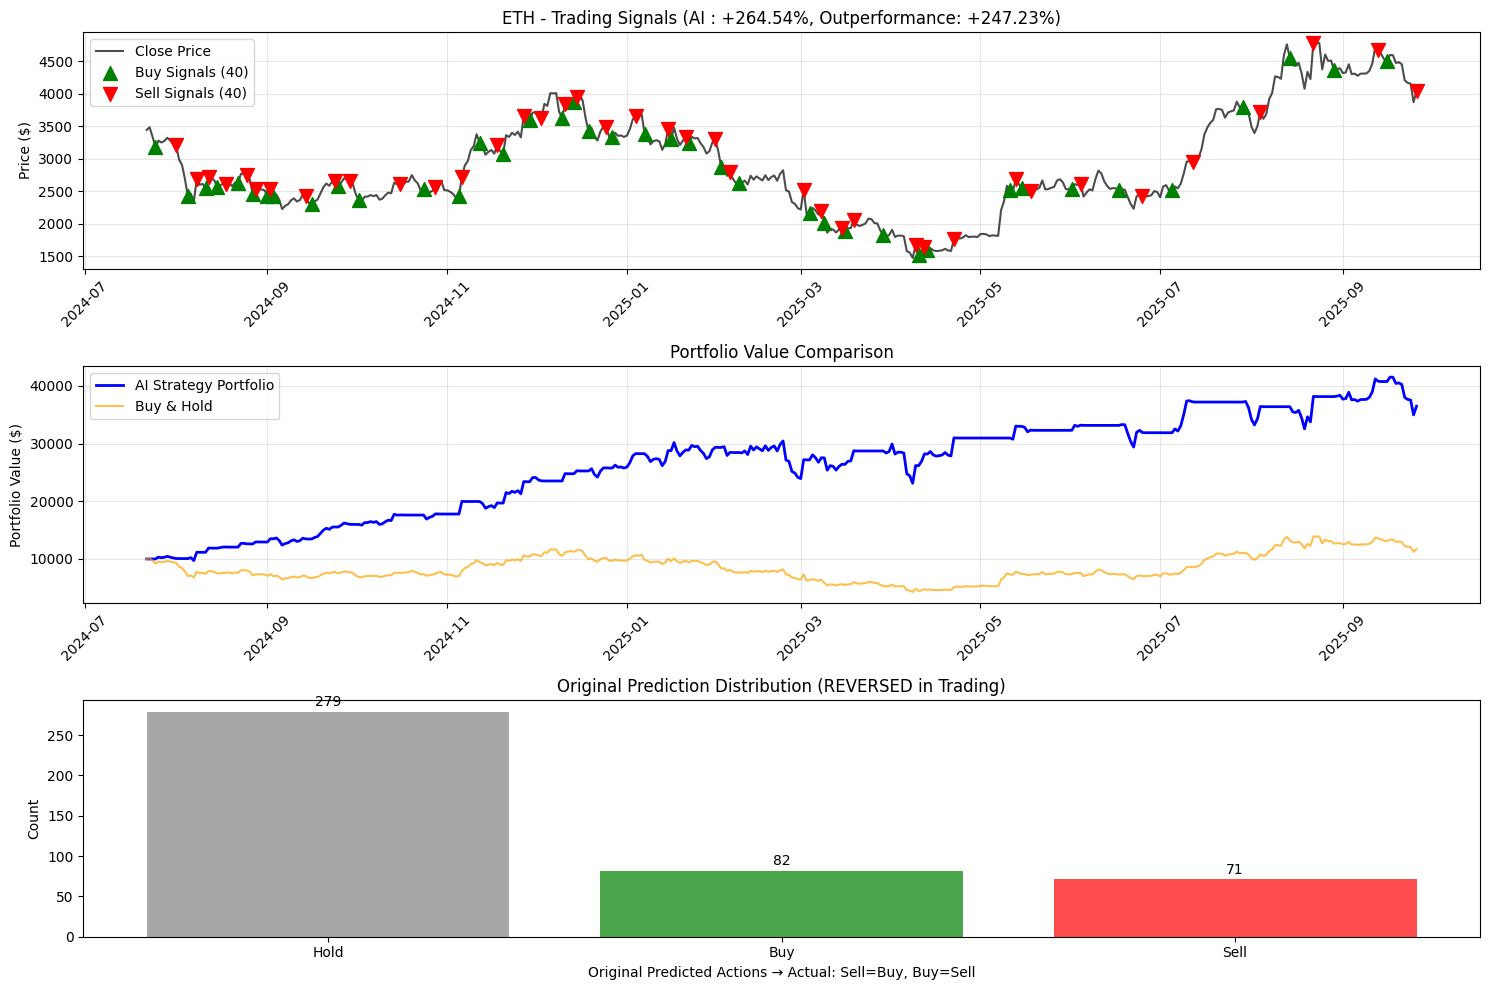


[2/12] CRO 차트 표시 중...

CRO 백테스팅 결과 (신호 반전 적용):
데이터 기간: 2024-09-20 ~ 2025-09-26
AI 전략 수익률:  305.70%
Buy & Hold 수익률:  127.35%
초과 수익률:  178.35%
샤프 비율: 1.57
최대 손실폭: -27.96%
총 거래 횟수: 74회
승률: 59.46%
평균 거래수익률: 5.21%
최종 자산: $40,570
✅ Buy 신호 → 매수, Sell 신호 → 매도


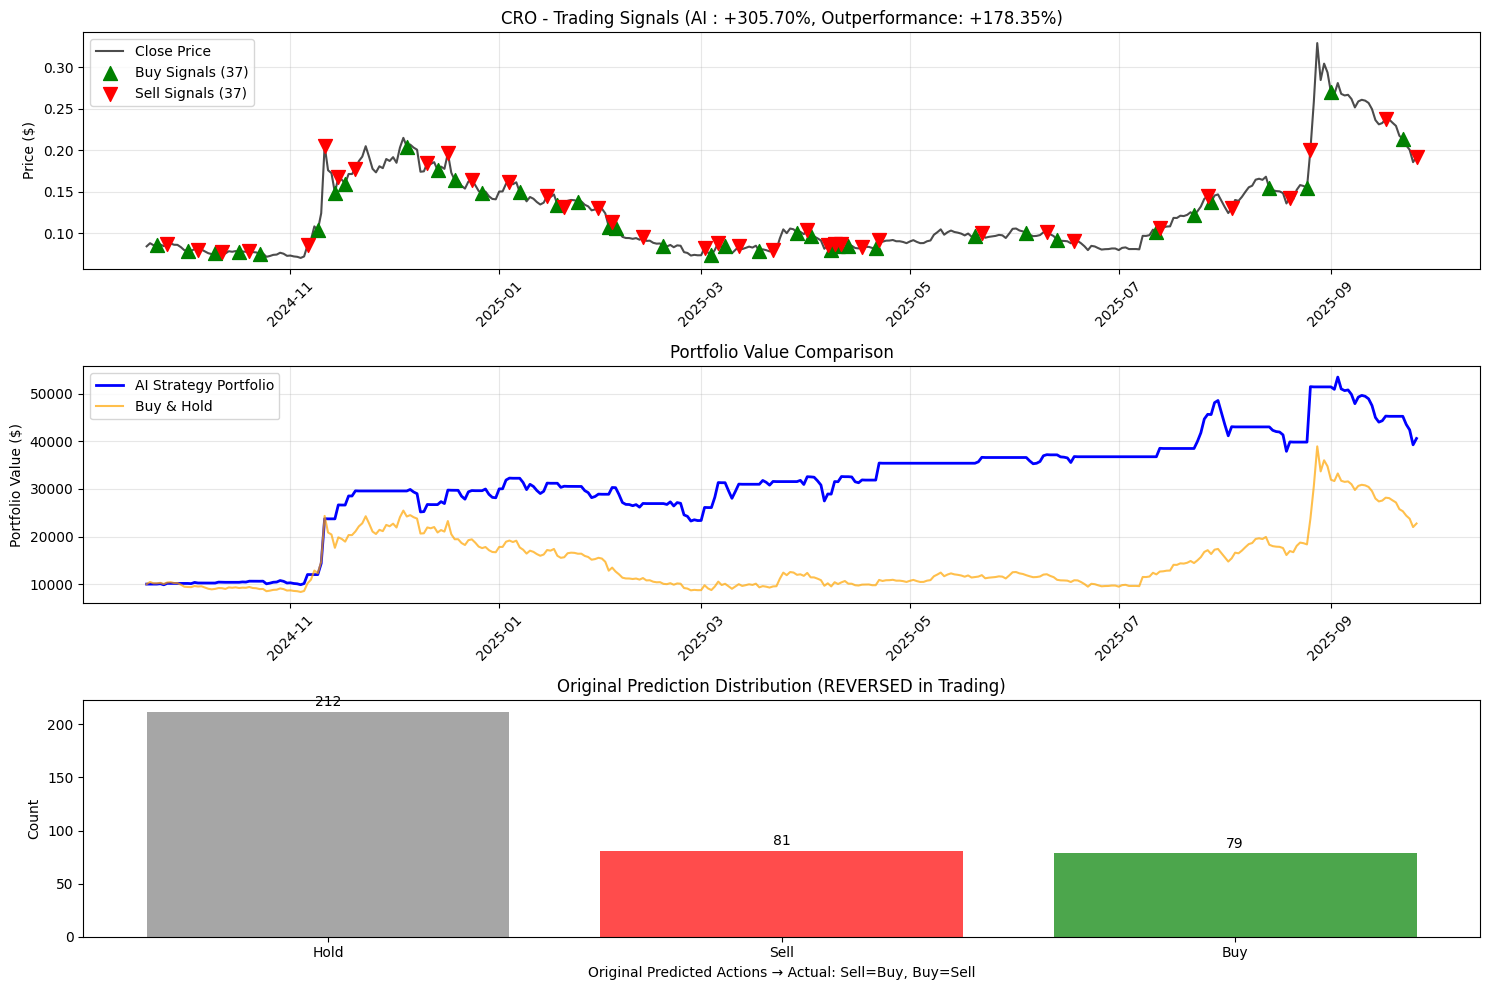


[3/12] WETH 차트 표시 중...

WETH 백테스팅 결과 (신호 반전 적용):
데이터 기간: 2024-08-01 ~ 2025-09-26
AI 전략 수익률:  194.70%
Buy & Hold 수익률:   25.95%
초과 수익률:  168.74%
샤프 비율: 1.73
최대 손실폭: -28.09%
총 거래 횟수: 82회
승률: 78.05%
평균 거래수익률: 3.02%
최종 자산: $29,470
✅ Buy 신호 → 매수, Sell 신호 → 매도


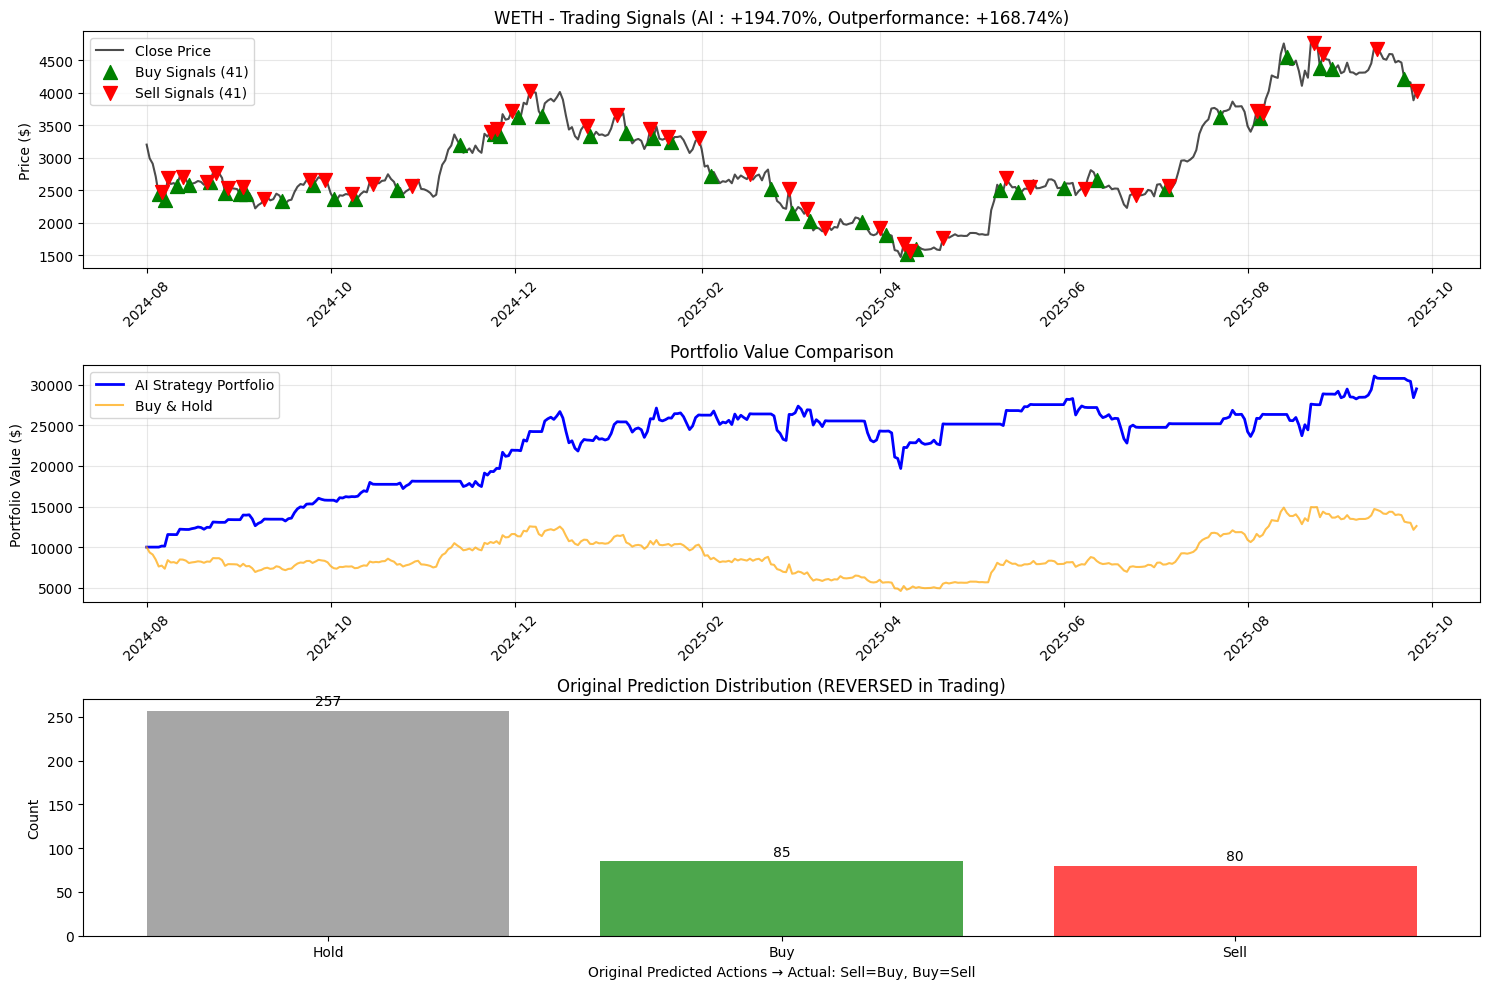


[4/12] SHIB 차트 표시 중...

SHIB 백테스팅 결과 (신호 반전 적용):
데이터 기간: 2024-12-24 ~ 2025-09-26
AI 전략 수익률:  103.37%
Buy & Hold 수익률:  -47.83%
초과 수익률:  151.20%
샤프 비율: 1.36
최대 손실폭: -27.37%
총 거래 횟수: 56회
승률: 50.00%
평균 거래수익률: 3.19%
최종 자산: $20,337
✅ Buy 신호 → 매수, Sell 신호 → 매도


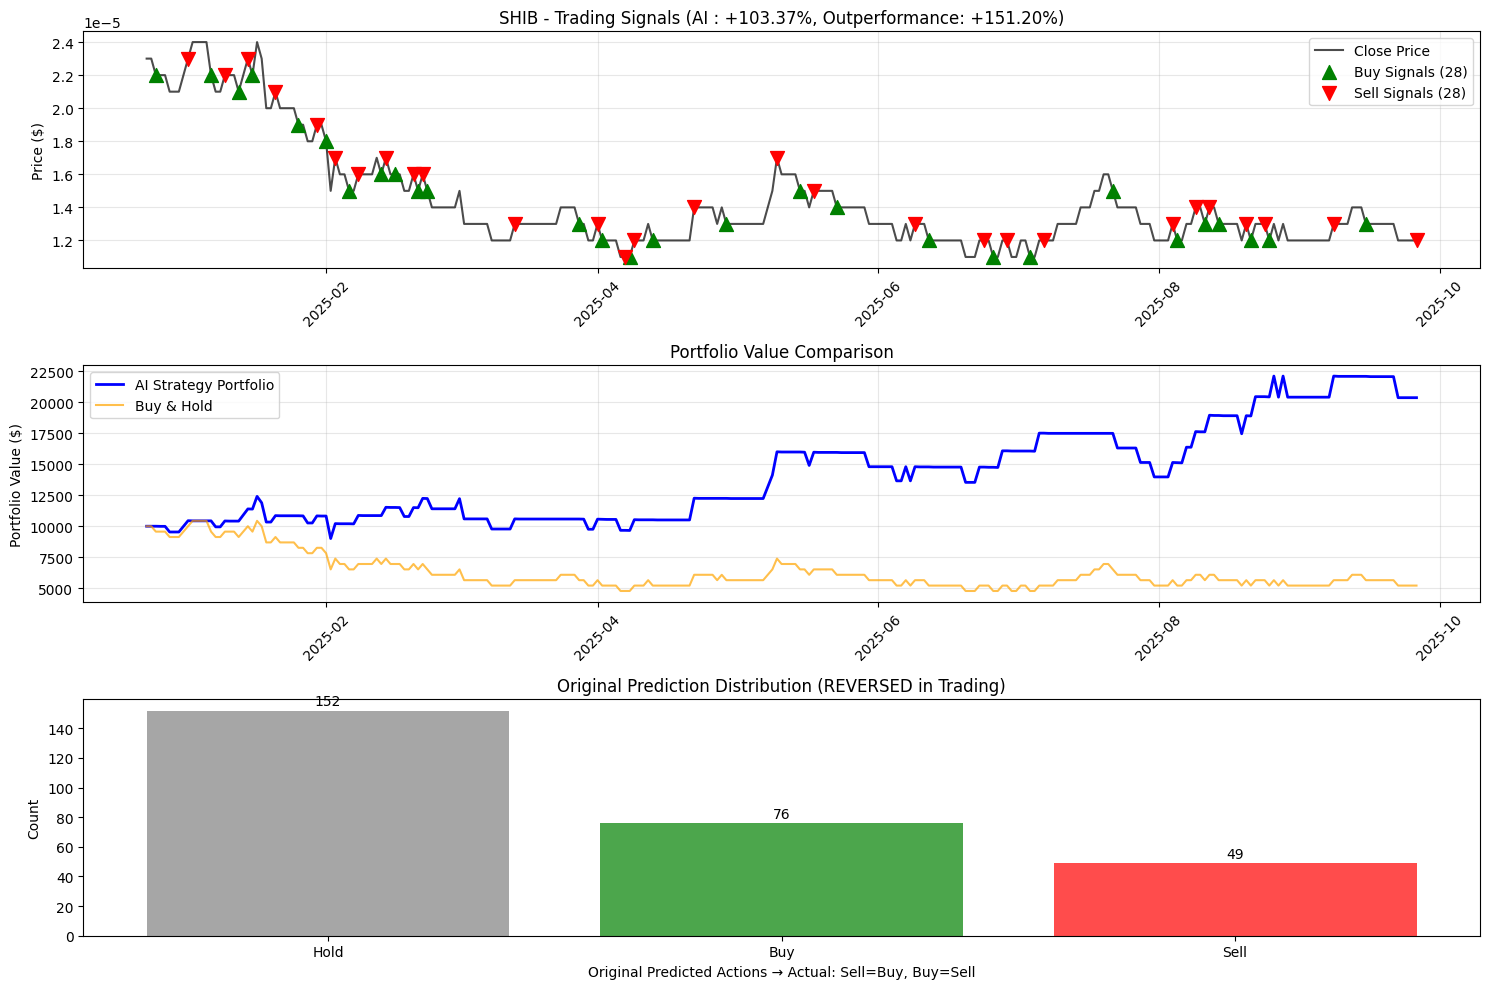


[5/12] BTC 차트 표시 중...

BTC 백테스팅 결과 (신호 반전 적용):
데이터 기간: 2024-02-16 ~ 2025-09-26
AI 전략 수익률:  215.76%
Buy & Hold 수익률:  110.34%
초과 수익률:  105.42%
샤프 비율: 1.97
최대 손실폭: -16.01%
총 거래 횟수: 76회
승률: 78.95%
평균 거래수익률: 3.39%
최종 자산: $31,576
✅ Buy 신호 → 매수, Sell 신호 → 매도


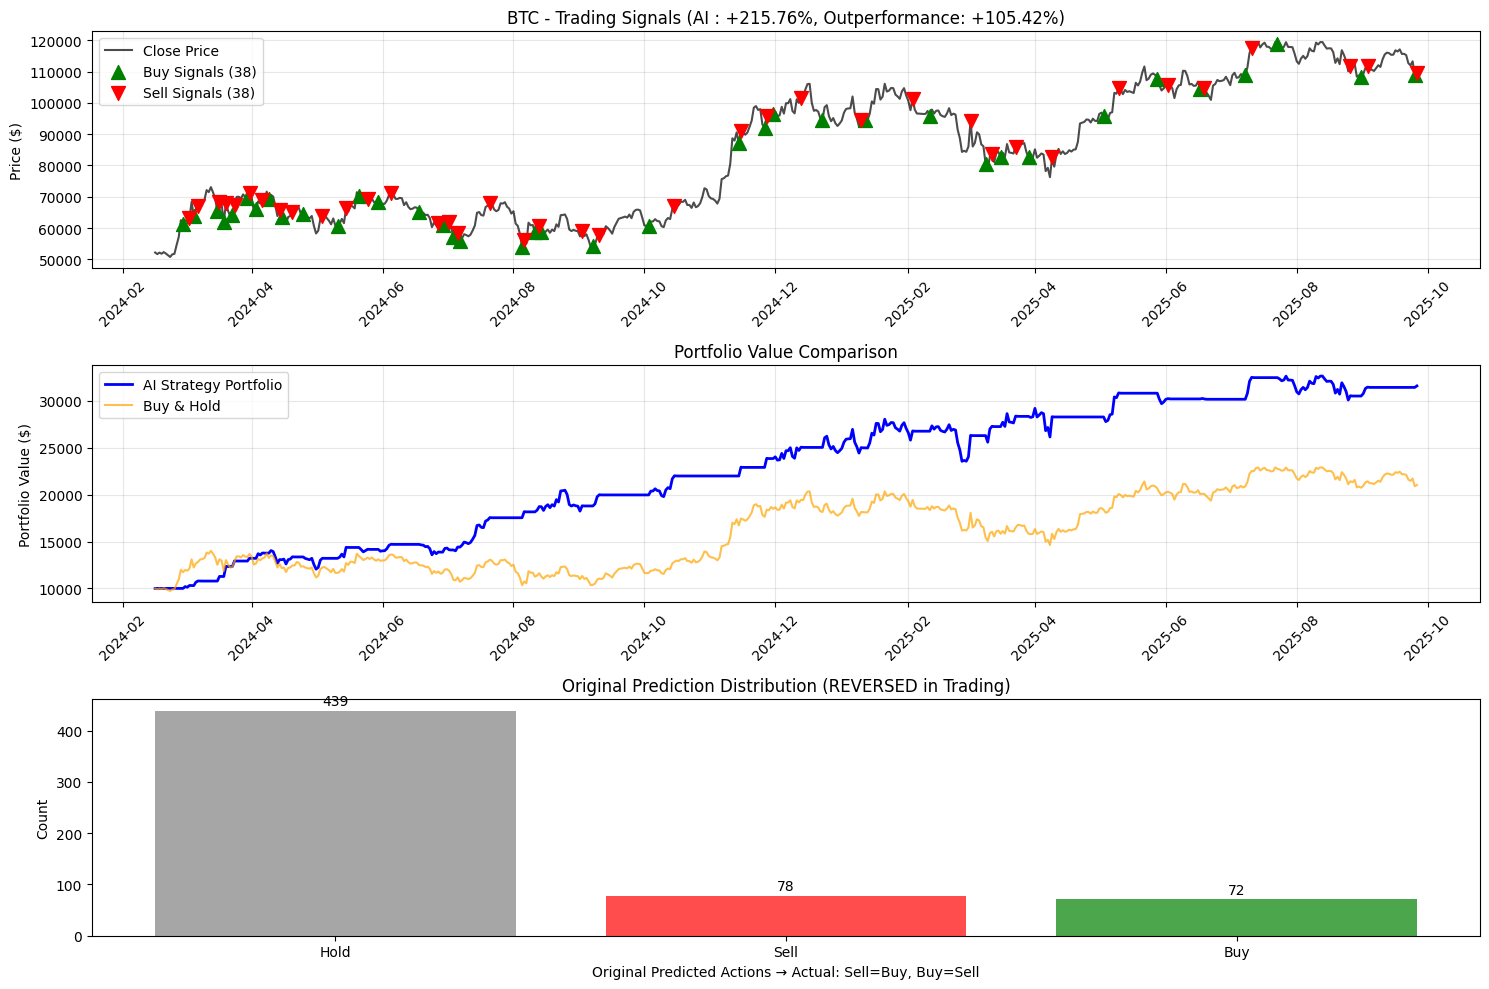


[6/12] DOT 차트 표시 중...

DOT 백테스팅 결과 (신호 반전 적용):
데이터 기간: 2024-12-21 ~ 2025-09-26
AI 전략 수익률:   56.47%
Buy & Hold 수익률:  -43.66%
초과 수익률:  100.13%
샤프 비율: 1.14
최대 손실폭: -25.34%
총 거래 횟수: 62회
승률: 67.74%
평균 거래수익률: 1.98%
최종 자산: $15,647
✅ Buy 신호 → 매수, Sell 신호 → 매도


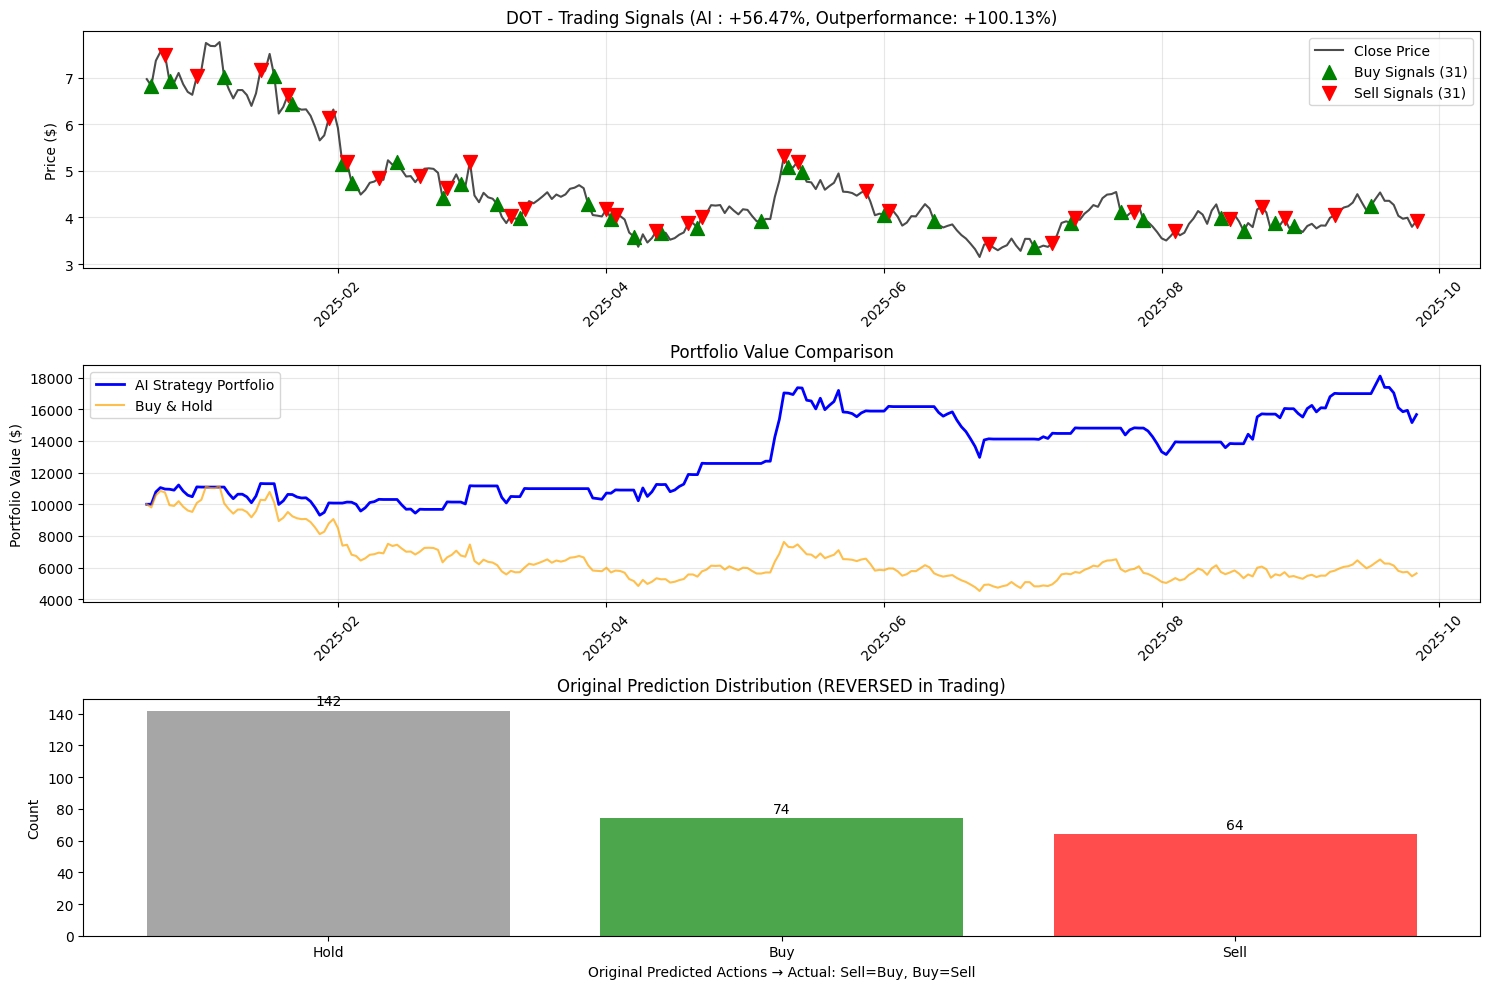


[7/12] BCH 차트 표시 중...

BCH 백테스팅 결과 (신호 반전 적용):
데이터 기간: 2024-07-22 ~ 2025-09-26
AI 전략 수익률:  135.64%
Buy & Hold 수익률:   42.18%
초과 수익률:   93.46%
샤프 비율: 1.33
최대 손실폭: -27.34%
총 거래 횟수: 88회
승률: 68.18%
평균 거래수익률: 2.43%
최종 자산: $23,564
✅ Buy 신호 → 매수, Sell 신호 → 매도


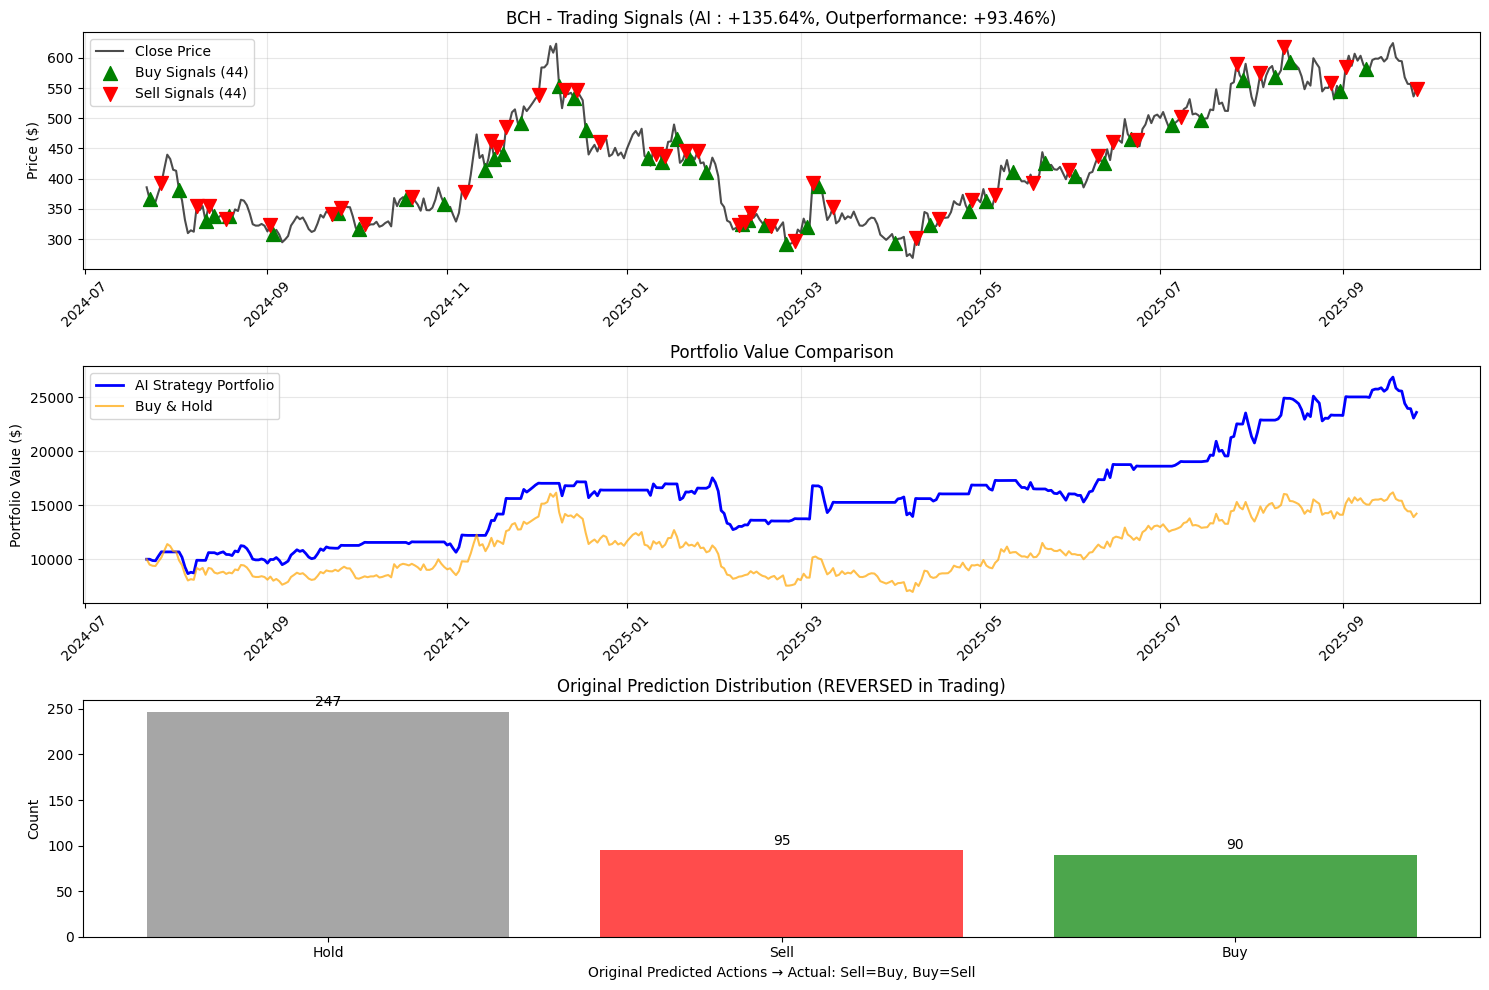


[8/12] AVAX 차트 표시 중...

AVAX 백테스팅 결과 (신호 반전 적용):
데이터 기간: 2024-12-26 ~ 2025-09-26
AI 전략 수익률:   50.74%
Buy & Hold 수익률:  -21.93%
초과 수익률:   72.66%
샤프 비율: 0.96
최대 손실폭: -30.35%
총 거래 횟수: 60회
승률: 63.33%
평균 거래수익률: 1.96%
최종 자산: $15,074
✅ Buy 신호 → 매수, Sell 신호 → 매도


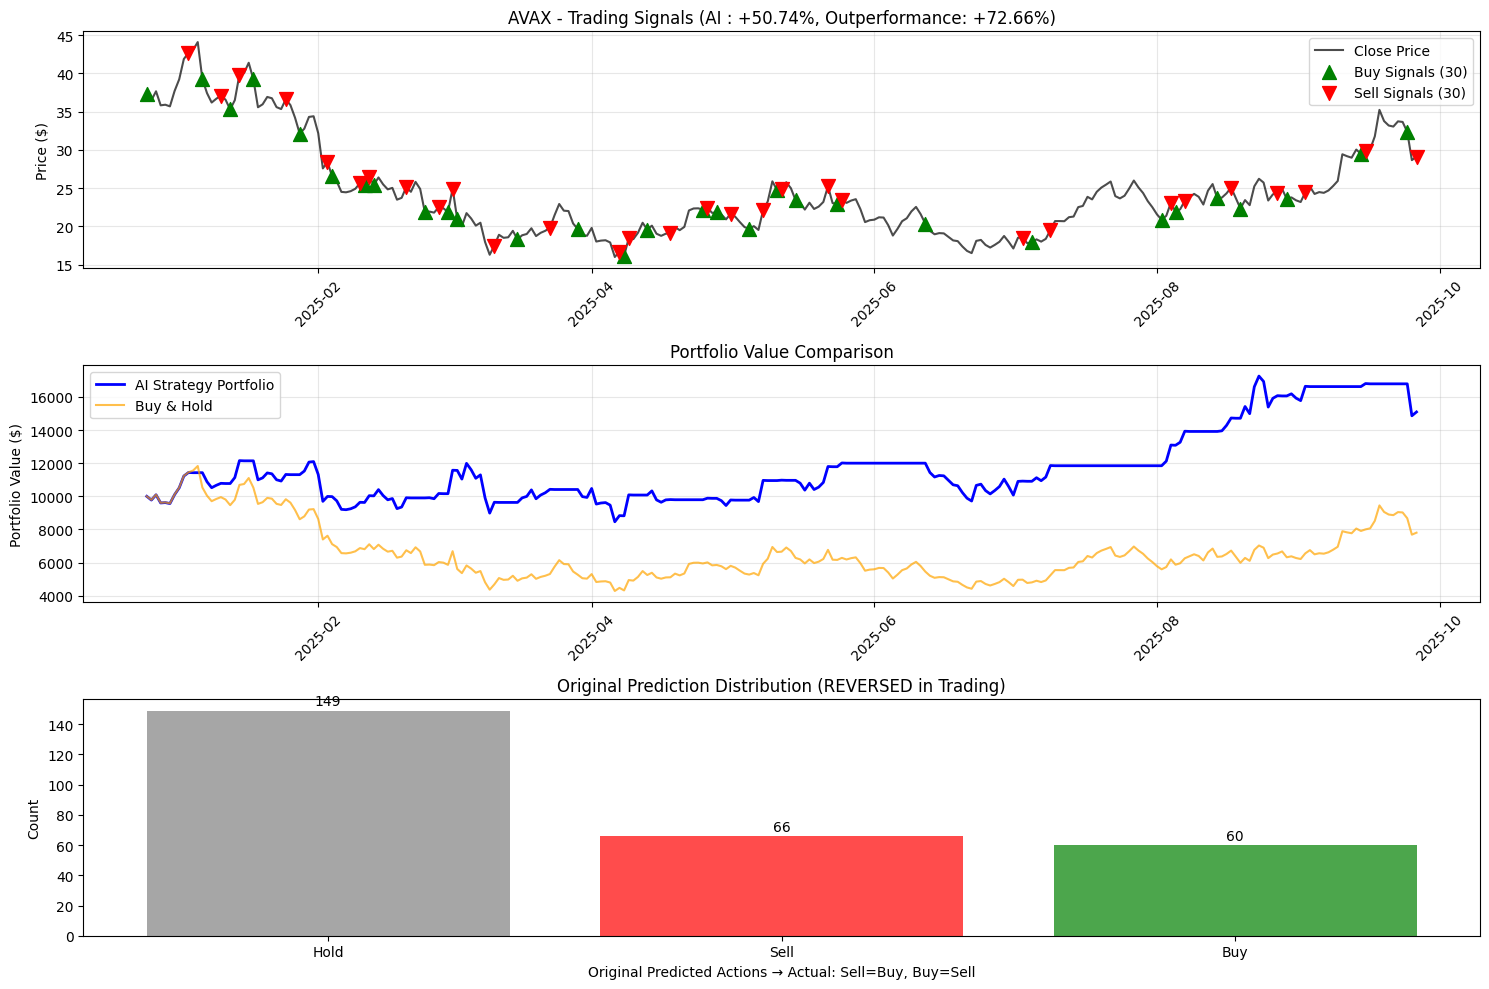


[9/12] WBTC 차트 표시 중...

WBTC 백테스팅 결과 (신호 반전 적용):
데이터 기간: 2024-09-27 ~ 2025-09-26
AI 전략 수익률:  137.69%
Buy & Hold 수익률:   66.99%
초과 수익률:   70.71%
샤프 비율: 2.42
최대 손실폭: -12.90%
총 거래 횟수: 46회
승률: 73.91%
평균 거래수익률: 4.15%
최종 자산: $23,769
✅ Buy 신호 → 매수, Sell 신호 → 매도


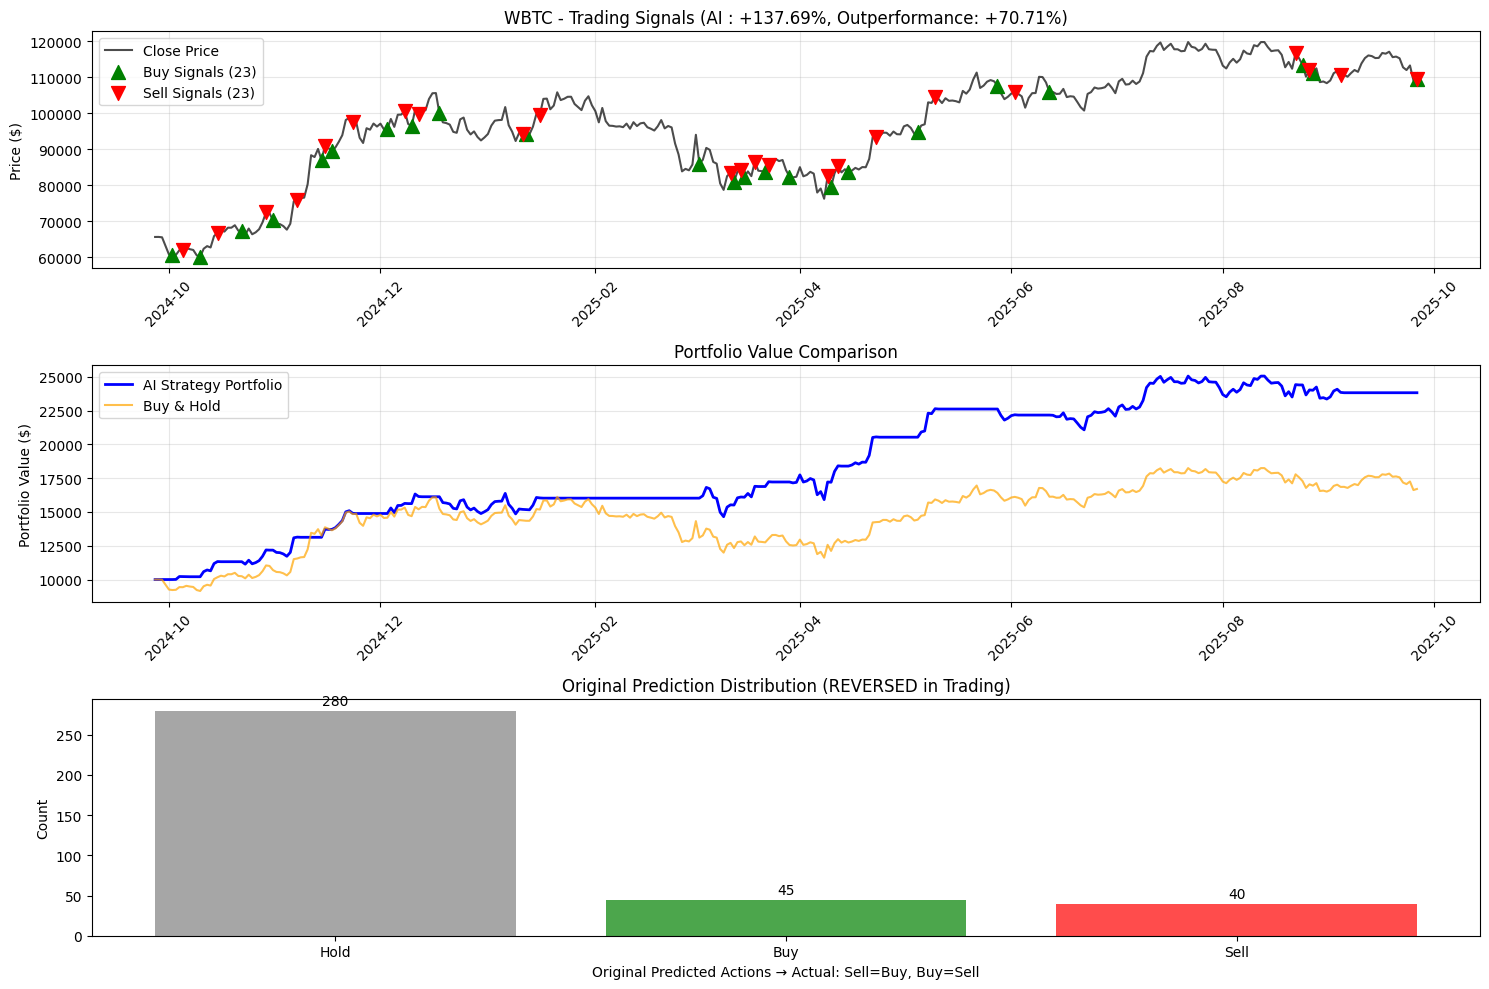


[10/12] LINK 차트 표시 중...

LINK 백테스팅 결과 (신호 반전 적용):
데이터 기간: 2024-07-22 ~ 2025-09-26
AI 전략 수익률:  120.26%
Buy & Hold 수익률:   51.38%
초과 수익률:   68.88%
샤프 비율: 1.03
최대 손실폭: -33.97%
총 거래 횟수: 82회
승률: 65.85%
평균 거래수익률: 2.85%
최종 자산: $22,026
✅ Buy 신호 → 매수, Sell 신호 → 매도


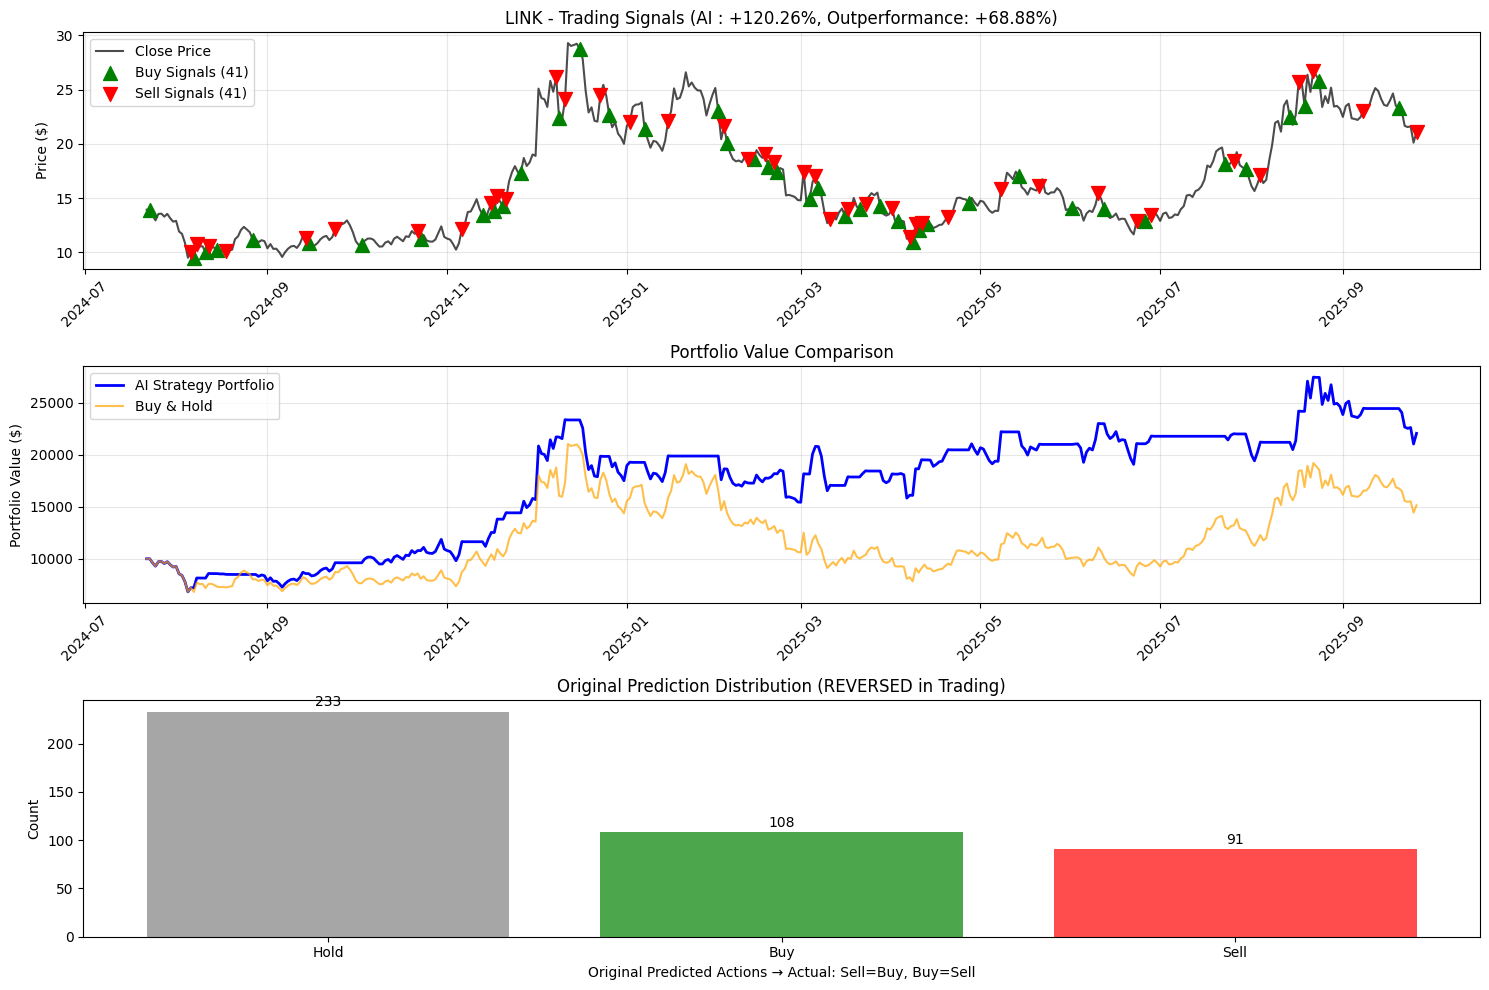


[11/12] STETH 차트 표시 중...

STETH 백테스팅 결과 (신호 반전 적용):
데이터 기간: 2025-01-09 ~ 2025-09-26
AI 전략 수익률:   81.80%
Buy & Hold 수익률:   25.26%
초과 수익률:   56.53%
샤프 비율: 1.41
최대 손실폭: -22.96%
총 거래 횟수: 52회
승률: 76.92%
평균 거래수익률: 2.85%
최종 자산: $18,180
✅ Buy 신호 → 매수, Sell 신호 → 매도


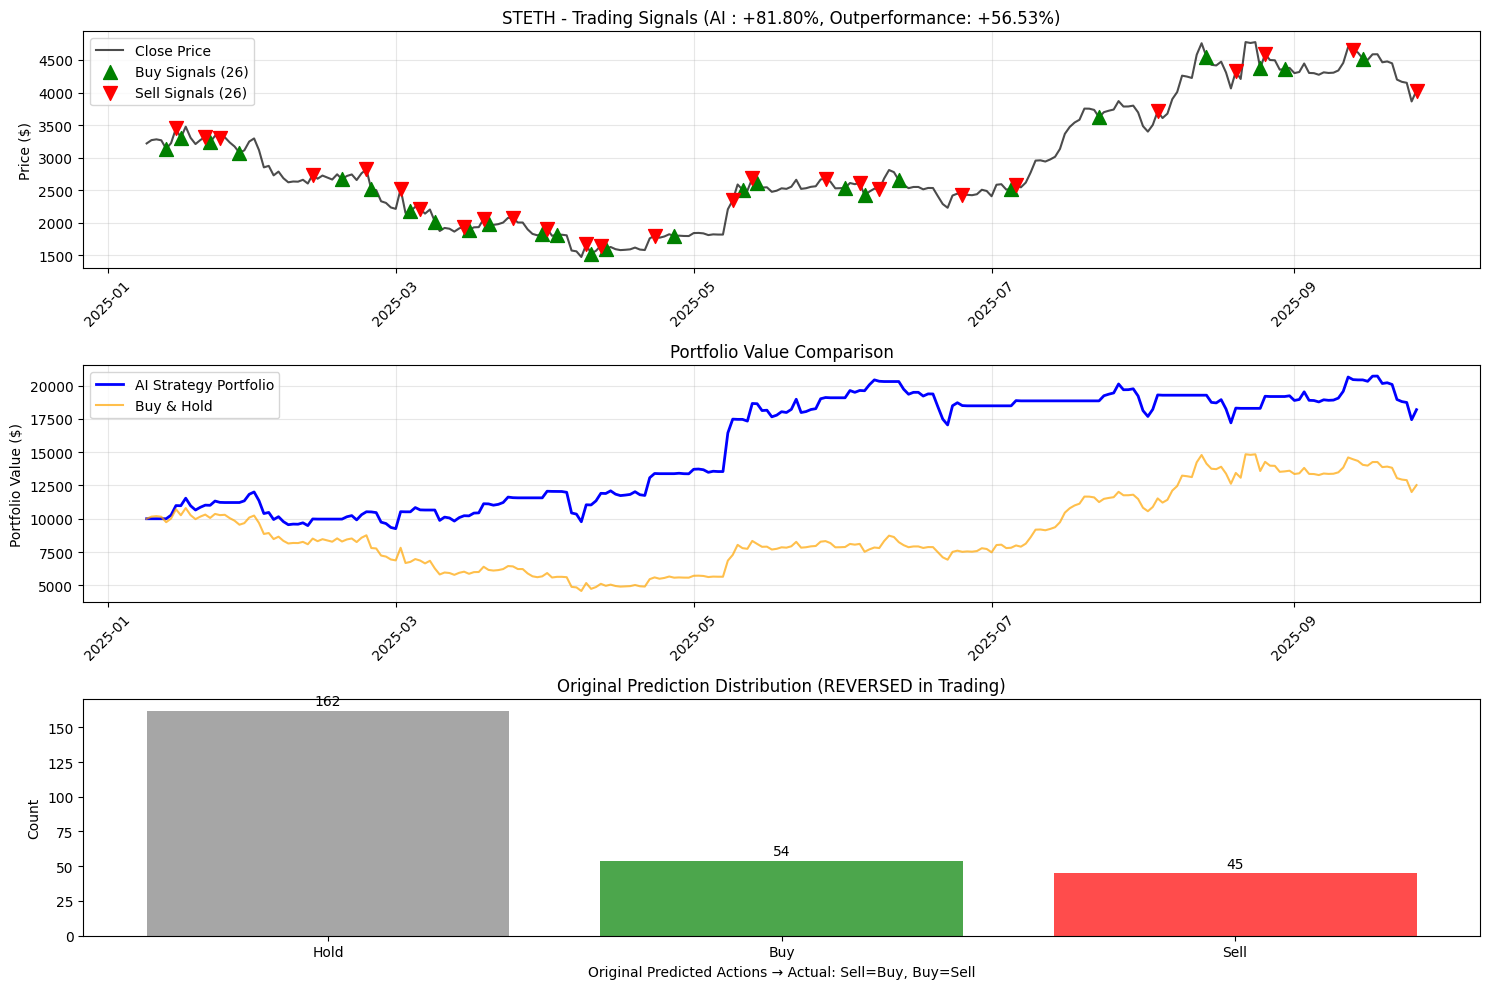


[12/12] UNI7083 차트 표시 중...

UNI7083 백테스팅 결과 (신호 반전 적용):
데이터 기간: 2024-12-25 ~ 2025-09-26
AI 전략 수익률:   -1.55%
Buy & Hold 수익률:  -45.10%
초과 수익률:   43.55%
샤프 비율: 0.27
최대 손실폭: -42.68%
총 거래 횟수: 66회
승률: 69.70%
평균 거래수익률: 0.62%
최종 자산: $9,845
✅ Buy 신호 → 매수, Sell 신호 → 매도


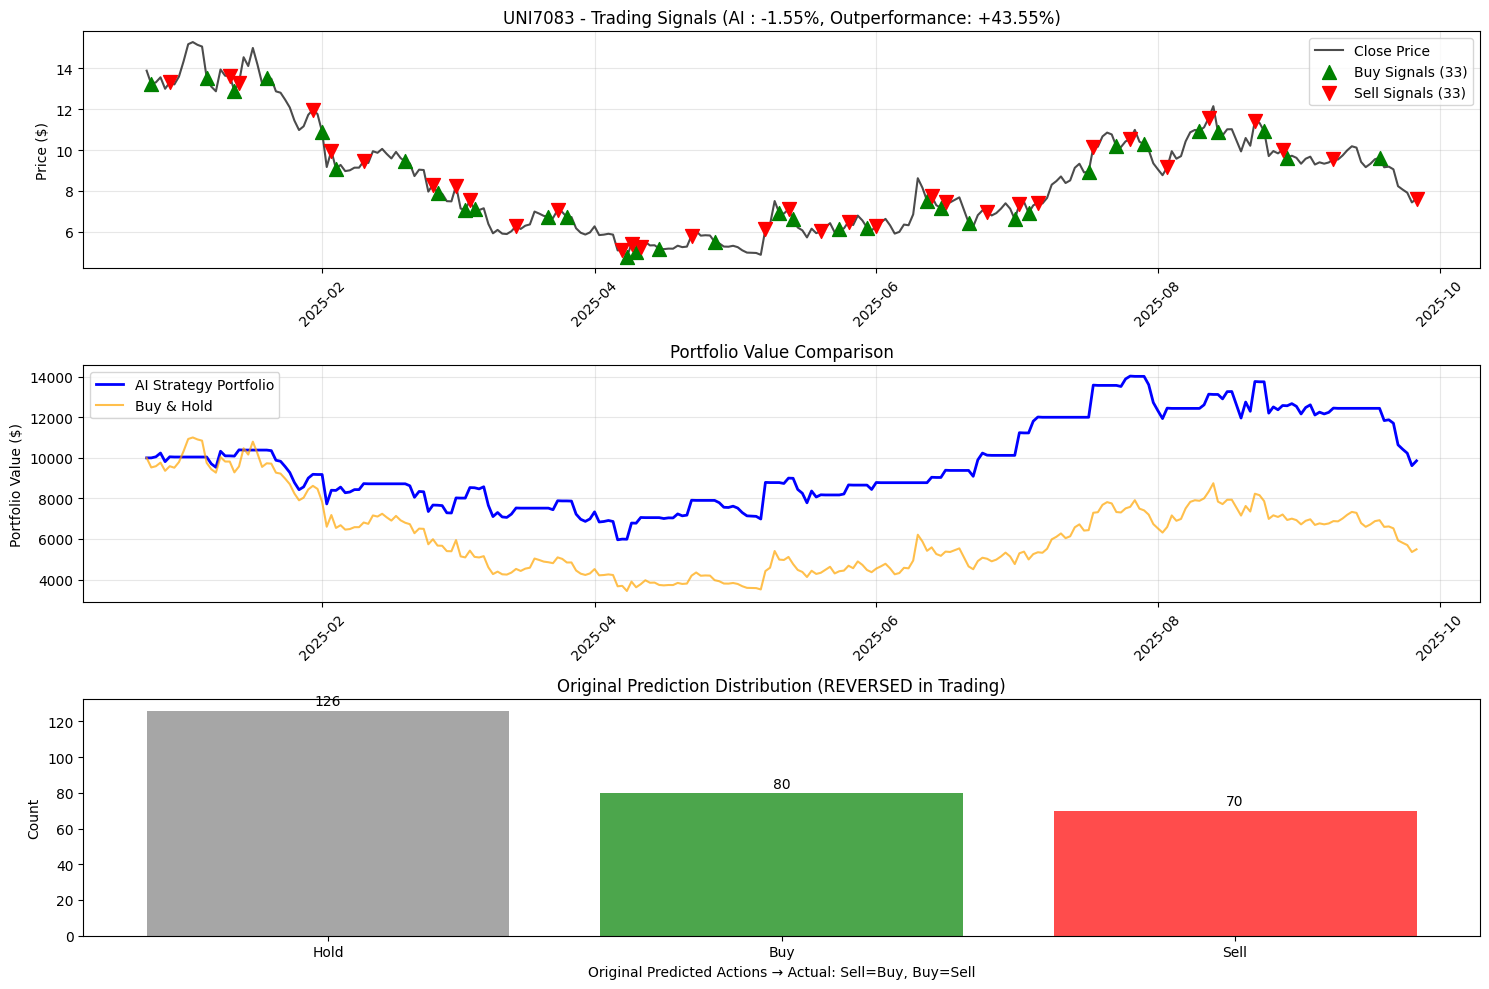

In [40]:
# 2. 다양한 차트 표시 방법들:
'''
# 2-1. 초과수익률 기준 상위 10% 개별 차트 표시
backtester.plot_top_performers(top_percentage=0.1, ranking_type='excess')

# 2-2. 전략수익률 기준 상위 25% 개별 차트 표시  
backtester.plot_top_performers(top_percentage=0.25, ranking_type='strategy')

# 2-3. 초과수익률 기준 상위 20% 한 화면에 표시
backtester.plot_top_performers_combined(top_percentage=0.2, ranking_type='excess', max_subplots=6)

# 2-4. 기존에 식별된 상위 종목들 표시 (기존 방식)
backtester.plot_top_performers()  # 기본값: ranking_type='excess'

# 2-5. 편의 함수 사용
plot_flexible_top_performers(backtester, top_percentage=0.15, ranking_type='strategy', display_type='combined')

# 2-6. 개별 종목 차트
backtester.plot_individual_stock('BTC')
'''

backtester.plot_top_performers(top_percentage=0.5, ranking_type='excess')